## Dependencies 

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import statsmodels.api as sm
import seaborn as sns

import pandas as pd
import numpy as np
from config import password


In [2]:
# Database dependencies
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# Database credentials
DATABASES = {
    'finalproject':{
        'POSTGRES_ADDRESS' :'finalproject.c969jxlkzz2v.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT' : '5432',
        'POSTGRES_USERNAME' : "postgres",
        'POSTGRES_PASSWORD' : password,
        'POSTGRES_DBNAME' : 'housingdata',
    },
}

# Choose the database to use
db = DATABASES['finalproject']

# Connect to postgres
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# Create an database engine instance
connection = create_engine(postgres_str)

## Load the datasets

In [3]:
df = pd.read_sql_table('final_table', connection)
df.head()

,city,total_pop,male,female,race_w,race_aa,race_nat,race_as,race_api,race_oth,...,med_age,zhvi,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson
0,Lake In The Hills,28886.0,14163.0,14723.0,26251.0,977.0,71.0,1979.0,117.0,428.0,...,35.1,235848.83,0,0,0,0,0,0,0,0
1,Lake Villa,35286.0,17646.0,17640.0,32294.0,900.0,131.0,1733.0,17.0,858.0,...,40.3,208693.58,1,4,0,4,3,29,1,0
2,Lake Zurich,42637.0,21299.0,21338.0,36357.0,1008.0,145.0,5008.0,124.0,868.0,...,42.0,429947.17,0,1,1,3,18,238,3,0
3,Lanark,2451.0,1181.0,1270.0,2352.0,23.0,51.0,14.0,0.0,76.0,...,51.3,195972.25,0,0,0,0,0,1,0,0
4,Lane,154.0,104.0,50.0,154.0,0.0,12.0,0.0,0.0,0.0,...,25.8,67665.92,0,0,0,0,0,0,0,0


## Data preprocessing

In [4]:
clean_df = df.drop(['city'],1)
clean_df.head()

,total_pop,male,female,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,...,med_age,zhvi,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson
0,28886.0,14163.0,14723.0,26251.0,977.0,71.0,1979.0,117.0,428.0,3487.0,...,35.1,235848.83,0,0,0,0,0,0,0,0
1,35286.0,17646.0,17640.0,32294.0,900.0,131.0,1733.0,17.0,858.0,3137.0,...,40.3,208693.58,1,4,0,4,3,29,1,0
2,42637.0,21299.0,21338.0,36357.0,1008.0,145.0,5008.0,124.0,868.0,3441.0,...,42.0,429947.17,0,1,1,3,18,238,3,0
3,2451.0,1181.0,1270.0,2352.0,23.0,51.0,14.0,0.0,76.0,113.0,...,51.3,195972.25,0,0,0,0,0,1,0,0
4,154.0,104.0,50.0,154.0,0.0,12.0,0.0,0.0,0.0,0.0,...,25.8,67665.92,0,0,0,0,0,0,0,0


In [5]:
clean_df.describe()

,total_pop,male,female,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,...,med_age,zhvi,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,...,647.000000,6.470000e+02,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,9870.341327,4850.743250,5019.598077,7753.002694,1076.334899,67.420089,626.179134,11.237241,581.477914,1585.143295,...,42.286361,1.654871e+05,1.137558,5.859351,19.267388,35.471406,36.727975,205.771252,23.652241,1.412674
std,13319.112549,6542.248324,6786.700437,10162.196101,3190.247113,117.393000,1516.443778,28.480045,2398.051586,4535.304118,...,6.231174,1.354226e+05,22.177261,71.234017,381.072332,605.855186,464.182003,2556.850031,399.165850,17.654704
min,58.000000,24.000000,25.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.500000,2.703808e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,866.500000,440.500000,438.500000,829.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14.500000,...,38.400000,8.407288e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2655.000000,1322.000000,1314.000000,2389.000000,32.000000,13.000000,19.000000,0.000000,18.000000,86.000000,...,41.800000,1.243535e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14607.500000,7218.500000,7669.500000,11428.000000,583.000000,81.500000,345.000000,8.000000,334.000000,1355.500000,...,45.700000,2.039538e+05,0.000000,2.000000,1.000000,6.000000,14.000000,79.500000,4.000000,0.000000
max,83147.000000,41769.000000,41378.000000,49654.000000,30695.000000,734.000000,9528.500000,256.000000,47835.000000,74180.000000,...,67.400000,1.360530e+06,563.000000,1798.000000,9684.000000,15312.000000,11686.000000,64695.000000,10132.000000,438.000000


In [6]:
# Split our preprocessed data into our features and target arrays
y = clean_df['zhvi']
X = clean_df.drop(['zhvi'], 1)

## Linear Regression

In [7]:
# Initiate Linear regression
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [8]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 -130385.4479307278
Coefficients: 
 [ 8.01832630e+00 -1.83901037e+01  2.64084300e+01 -1.28451041e+01
 -1.49616170e+01 -2.82593411e+01 -4.12731626e+00  1.59007669e+01
 -1.88701361e+01  5.97909026e+00  2.03923604e+00  4.28740639e+00
 -3.75851177e+02 -4.16674657e+03 -1.41417871e+03  1.26163878e+02
 -1.35007653e+02  4.98076417e+02  3.83221276e+00  1.28010842e+02
 -3.33643140e+03]


In [9]:
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   zhvi   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     87.98
Date:                Fri, 12 Feb 2021   Prob (F-statistic):          1.39e-162
Time:                        13:49:19   Log-Likelihood:                -8142.3
No. Observations:                 647   AIC:                         1.632e+04
Df Residuals:                     627   BIC:                         1.641e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.304e+05   2.28e+04     -5.713

## Random Forest Regressor

In [10]:
# Split and Train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [11]:
# Create a StandardScaler instances
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
## Train the model
model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
# Predict
y_pred = model_1.predict(X_test)

In [14]:
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,113696.446500,72555.250000
1,365069.474850,223538.500000
2,303077.963867,290179.500000
3,52618.173200,81606.420000
4,235710.326700,255532.330000
5,140512.873200,147782.420000
6,77677.403600,78285.170000
7,271547.767793,330427.580000
8,279407.008200,266229.330000
9,80740.902767,71437.580000


In [15]:
# Evaluate the model
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
rmse

50116.40449922593

In [16]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 33221.722203729514
Mean Squared Error: 2511653999.930033
Root Mean Squared Error: 50116.40449922593


Text(0.5, 0, 'Random Forest Feature Importance')

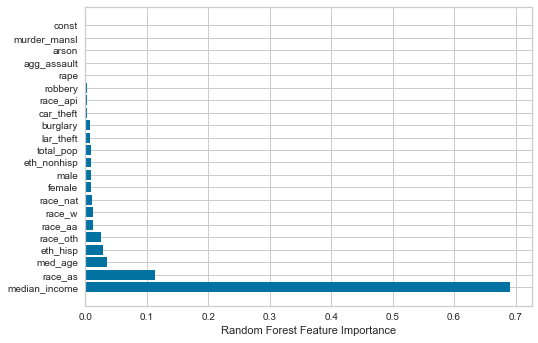

In [17]:
# List the features sorted in descending order by feature importance
features = (sorted(zip(model_1.feature_importances_, X.columns), reverse=True))

vals = [f for f,x in features]
names = [x for f,x in features]

plt.barh(names, vals)
plt.xlabel("Random Forest Feature Importance")

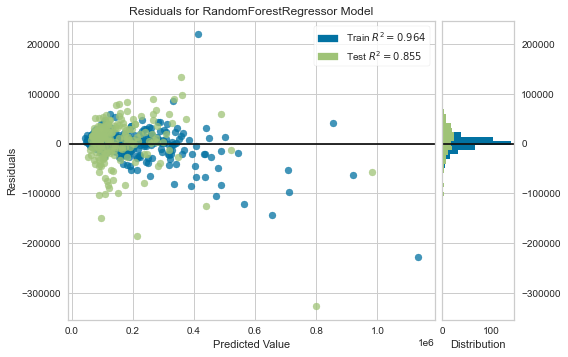

In [18]:
# Create the visualizer, fit, score, and show it
X, y = load_concrete()
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

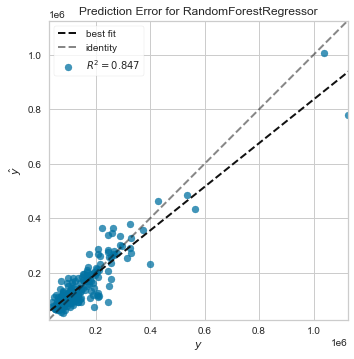

In [19]:
# Instantiate the linear model and visualizer
visualizer = prediction_error(model_1, X_train, y_train, X_test, y_test)